# Analysis of Grinding Simulation Data

In [1]:
from platform import python_version
python_version()

'3.7.6'

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

%matplotlib inline

In [3]:
plot_dir = '../../plots'
data_dir = '../../data'

## Simulation 1 - open loop

In [4]:
# Read data from file
data_filename = 'sim_ss_2020-04-13.csv'
filepath = os.path.join(data_dir, data_filename)
sim_data = pd.read_csv(filepath)
nt = sim_data.shape[0]
sim_data.shape

(11000, 82)

In [5]:
sim_data.head()

,Timestep,Time (mins),Charge Filling (%),Speed (% Critical),Power (kW),Make-up Feed [1],Make-up Feed [2],Make-up Feed [3],Make-up Feed [4],Make-up Feed [5],...,Mill Discharge [18],Mill Discharge [19],Mill Discharge [20],Mill Discharge [21],Mill Discharge [22],Mill Discharge [23],Mill Discharge [24],Mill Discharge [25],Net Feedrate (ton/hr),Mill Discharge (ton/hr)
0,0.0,0.5,51.293234,68.0,8992.045174,0.640239,0.959246,1.364199,2.616283,3.435867,...,1.165436,1.082931,0.946418,0.873010,0.950730,0.761578,0.651125,4.965763,1600.0,2060.479603
1,1.0,1.0,51.012210,68.0,9012.246786,0.730177,0.486831,0.977774,2.787712,2.867663,...,1.262394,1.208038,1.070895,1.076396,1.136143,0.938579,0.777012,5.910289,1600.0,2177.729715
2,2.0,1.5,50.689461,68.0,9034.815426,0.449112,1.467526,1.437201,2.362017,3.177435,...,1.247580,1.170740,1.120762,1.129246,1.246792,1.045256,0.923257,6.505925,1600.0,2222.305998
3,3.0,2.0,50.351224,68.0,9057.741521,0.543683,0.511191,1.626371,2.710941,2.412677,...,1.154680,1.190298,1.177991,1.165198,1.257861,1.096584,0.987502,6.865916,1600.0,2238.458224
4,4.0,2.5,50.010173,68.0,9080.106468,0.317217,0.984287,1.305303,2.259159,2.580799,...,1.087499,1.224770,1.158112,1.183705,1.237762,1.158198,0.990956,7.163079,1600.0,2234.984669


In [6]:
sim_data.columns

Index(['Timestep', 'Time (mins)', 'Charge Filling (%)', 'Speed (% Critical)',
       'Power (kW)', 'Make-up Feed [1]', 'Make-up Feed [2]',
       'Make-up Feed [3]', 'Make-up Feed [4]', 'Make-up Feed [5]',
       'Make-up Feed [6]', 'Make-up Feed [7]', 'Make-up Feed [8]',
       'Make-up Feed [9]', 'Make-up Feed [10]', 'Make-up Feed [11]',
       'Make-up Feed [12]', 'Make-up Feed [13]', 'Make-up Feed [14]',
       'Make-up Feed [15]', 'Make-up Feed [16]', 'Make-up Feed [17]',
       'Make-up Feed [18]', 'Make-up Feed [19]', 'Make-up Feed [20]',
       'Make-up Feed [21]', 'Make-up Feed [22]', 'Make-up Feed [23]',
       'Make-up Feed [24]', 'Make-up Feed [25]', 'Internal Charge [1]',
       'Internal Charge [2]', 'Internal Charge [3]', 'Internal Charge [4]',
       'Internal Charge [5]', 'Internal Charge [6]', 'Internal Charge [7]',
       'Internal Charge [8]', 'Internal Charge [9]', 'Internal Charge [10]',
       'Internal Charge [11]', 'Internal Charge [12]', 'Internal Charge [13]'

In [7]:
def plot_sim_results(sim_data, 
                     params=('speed', 'load', 'feed', 'discharge', 'charge'),
                     figsize=(9,5.5), filename=None):

    t = sim_data['Time (mins)']
    speed_pct_values = sim_data['Speed (% Critical)']
    charge_filling_levels = sim_data['Charge Filling (%)']
    feed_rates = sim_data['Net Feedrate (ton/hr)']
    discharge_rates = sim_data['Mill Discharge (ton/hr)']
    charge_cols = [s for s in sim_data if s.startswith('Internal Charge')]
    charge_weights = sim_data.set_index('Time (mins)')[charge_cols]

    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)

    style = '-' if speed_pct_values.shape[0] > 51 else '.-'

    ax = axes[0]
    ax.plot(t, speed_pct_values, style, label='speed')
    if 'Charge Filling SP (%)' in sim_data:
        ax.plot(t, sim_data['Charge Filling SP (%)'], linestyle='--', 
                label='load s.p.')
    ax.plot(t, charge_filling_levels, style, label='load')
    ax.set_ylim(25,90)
    ax.set_title('Speed and Filling Level')
    ax.set_xlabel('t')
    ax.set_ylabel('(%)')
    ax.grid()
    ax.legend()

    ax = axes[1]
    ax.plot(t, feed_rates, style, label='feed')
    ax.plot(t, discharge_rates, style, label='discharge')
    ax.set_title('Feed and Discharge Rates')
    ax.set_ylabel('Tons / hr')
    ax.grid()
    ax.legend()

    ax = axes[2]
    charge_weights.plot.area(ax=ax, stacked=True, legend=False)
    ax.set_title('Mill Charge')
    ax.set_xlabel('t (mins)')
    ax.set_ylabel('Tons')
    ax.grid()

    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(plot_dir, filename))
    plt.show()

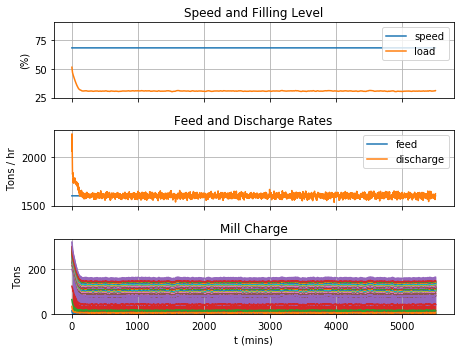

In [8]:
plot_sim_results(sim_data, figsize=(6.5,5),
                 filename = f"sim_results_1_{nt}.png")

In [9]:
charge_cols = [s for s in sim_data if s.startswith('Internal Charge')]
feed_cols = [s for s in sim_data if s.startswith('Make-up Feed')]

# Ignore the first 1000 timesteps
k_start = 1000
u_data = sim_data.loc[k_start:, feed_cols]
x_data = sim_data.loc[k_start:, charge_cols]
assert u_data.shape == (10000, 25)
assert x_data.shape == u_data.shape

In [10]:
speed_pct_values = sim_data.loc[k_start:, 'Speed (% Critical)']
charge_filling_levels = sim_data.loc[k_start:, 'Charge Filling (%)']
feed_rates = sim_data.loc[k_start:, 'Net Feedrate (ton/hr)']
discharge_rates = sim_data.loc[k_start:, 'Mill Discharge (ton/hr)']

pd.concat([speed_pct_values, charge_filling_levels,
           feed_rates, discharge_rates], axis=1).describe()

,Speed (% Critical),Charge Filling (%),Net Feedrate (ton/hr),Mill Discharge (ton/hr)
count,10000.0,10000.000000,10000.0,10000.000000
mean,68.0,30.713812,1600.0,1599.939934
std,0.0,0.170676,0.0,17.010041
min,68.0,30.184793,1600.0,1533.050182
25%,68.0,30.598897,1600.0,1588.438773
50%,68.0,30.719012,1600.0,1600.000243
75%,68.0,30.826746,1600.0,1611.588385
max,68.0,31.228669,1600.0,1665.836566


## Simulation 2 - open loop

In [11]:
# Read data from file
data_filename = 'sim_clis_2020-04-13.csv'
filepath = os.path.join(data_dir, data_filename)
sim_data = pd.read_csv(filepath)
nt = sim_data.shape[0]
sim_data.shape

(11000, 83)

In [12]:
sim_data.head()

,Timestep,Time (mins),Charge Filling (%),Speed (% Critical),Power (kW),Make-up Feed [1],Make-up Feed [2],Make-up Feed [3],Make-up Feed [4],Make-up Feed [5],...,Mill Discharge [19],Mill Discharge [20],Mill Discharge [21],Mill Discharge [22],Mill Discharge [23],Mill Discharge [24],Mill Discharge [25],Net Feedrate (ton/hr),Mill Discharge (ton/hr),Charge Filling SP (%)
0,0.0,0.5,51.393438,68.0,8984.717927,0.683564,0.654587,0.980051,2.665994,3.351838,...,1.019185,0.978410,0.941030,0.825406,0.812527,0.689978,4.979622,1800.000000,2086.113739,30.7
1,1.0,1.0,50.814753,68.0,9026.134570,0.305696,0.664244,0.910091,1.488350,1.842460,...,1.121699,1.112223,1.043790,0.937088,0.924343,0.882223,5.940930,1051.441814,2169.009057,30.7
2,2.0,1.5,50.267238,68.0,9063.319096,0.379437,0.471396,0.817752,1.808835,2.074605,...,1.182139,1.169216,1.115296,1.019818,1.005057,0.985892,6.491702,1163.271425,2199.728020,30.7
3,3.0,2.0,49.742839,68.0,9097.109492,0.724820,0.492145,1.148102,1.912246,1.964538,...,1.152929,1.190802,1.167539,1.085171,1.108899,1.025332,6.825744,1221.366097,2200.157920,30.7
4,4.0,2.5,49.237841,68.0,9127.962612,0.561115,0.706096,0.722924,2.355721,2.401289,...,1.130029,1.155895,1.186139,1.154697,1.156619,1.017797,7.069071,1248.015962,2182.996905,30.7


In [13]:
sim_data.columns

Index(['Timestep', 'Time (mins)', 'Charge Filling (%)', 'Speed (% Critical)',
       'Power (kW)', 'Make-up Feed [1]', 'Make-up Feed [2]',
       'Make-up Feed [3]', 'Make-up Feed [4]', 'Make-up Feed [5]',
       'Make-up Feed [6]', 'Make-up Feed [7]', 'Make-up Feed [8]',
       'Make-up Feed [9]', 'Make-up Feed [10]', 'Make-up Feed [11]',
       'Make-up Feed [12]', 'Make-up Feed [13]', 'Make-up Feed [14]',
       'Make-up Feed [15]', 'Make-up Feed [16]', 'Make-up Feed [17]',
       'Make-up Feed [18]', 'Make-up Feed [19]', 'Make-up Feed [20]',
       'Make-up Feed [21]', 'Make-up Feed [22]', 'Make-up Feed [23]',
       'Make-up Feed [24]', 'Make-up Feed [25]', 'Internal Charge [1]',
       'Internal Charge [2]', 'Internal Charge [3]', 'Internal Charge [4]',
       'Internal Charge [5]', 'Internal Charge [6]', 'Internal Charge [7]',
       'Internal Charge [8]', 'Internal Charge [9]', 'Internal Charge [10]',
       'Internal Charge [11]', 'Internal Charge [12]', 'Internal Charge [13]'

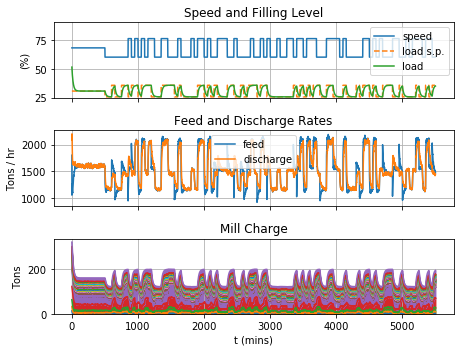

In [14]:
plot_sim_results(sim_data, figsize=(6.5,5),
                 filename = f"sim_results_2_{nt}.png")